# Audio Deepfake Detection

As AI-generated audio becomes increasingly realistic, telling it apart from genuine human speech is becoming more difficult. Advanced text-to-speech (TTS) technologies such as F5-TTS, ElevenLabs, and other neural voice synthesis tools can now produce speech that sounds natural and convincing to most listeners. This raises several concerns:

- Security: Voice-based authentication methods may be vulnerable

- Misinformation: Fake audio recordings could mislead the public

- Trust: It’s harder to verify the authenticity of audio content

- Legal: Challenges may arise in validating audio evidence and testimony

This notebook explores methods for detecting synthetic speech and presents a system designed to help identify deepfake audio with a high degree of accuracy. It is designed to analyze a single audio files in common formats (WAV, MP3, FLAC, etc.)

- Audio Requirements:

  - Minimum 3 seconds of speech for reliable detection
  - Sample rates automatically normalized to 16kHz
  - Works best with clear speech, minimal background noise

- No Training Data Required: Uses pre-trained models, so you only need the audio file you want to verify

The detection methodology combines multiple complementary techniques:

1. Signal Processing Analysis

- Extract 50+ acoustic features (MFCCs, spectral features, temporal patterns)
- Analyze phase coherence and formant stability
- Examine micro-temporal artifacts common in synthetic speech


2. Deep Learning Models

- Primary: MelodyMachine's dedicated deepfake detection model (50% weight)
- Secondary: Wav2Vec2 for audio feature extraction
- Ensemble approach for robust detection


3. Visual Analysis

- Generate spectrograms and mel-spectrograms
- Plot temporal and spectral features over time
- Visualize phase patterns and pitch contours


4. Comprehensive Scoring

- Weighted ensemble of all indicators
- Component-wise breakdown for interpretability
- Confidence levels and risk assessment



Key Technologies

- Core Libraries: `librosa` for audio processing, `torch` and `transformers` for ML models
- Visualization: `matplotlib` and `seaborn` for detailed plots
- Signal Processing: `scipy` for advanced audio analysis
- Pre-trained Models: HuggingFace transformers ecosystem



Clear Detection Result: A score from 0-1 indicating deepfake likelihood

- 0.0-0.4: Low risk (likely genuine)
- 0.4-0.7: Medium risk (suspicious)
- 0.7-1.0: High risk (likely deepfake)


Visual Evidence: Multiple plots showing:

- Waveform and spectrograms with potential artifacts highlighted
- Feature evolution over time
- Component scores breakdown


Detailed Analysis:

- Which specific features triggered detection
- Model predictions with confidence scores


In [1]:
#!pip install torch torchaudio transformers librosa matplotlib seaborn numpy scipy pandas scikit-learn audioread soundfile tf-keras

In [2]:
# Import required packages

import torch
import torchaudio
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import kurtosis, skew
import pandas as pd
from transformers import pipeline, AutoProcessor, AutoModelForAudioClassification
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
def load_audio(file_path, target_sr=16000):
    """
    Load audio file and resample to target sampling rate
    """
    try:
        # Try loading with librosa first
        audio, sr = librosa.load(file_path, sr=None)
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
    except:
        # Fallback to torchaudio
        waveform, sr = torchaudio.load(file_path)
        if sr != target_sr:
            resampler = torchaudio.transforms.Resample(sr, target_sr)
            waveform = resampler(waveform)
            sr = target_sr
        audio = waveform.numpy().squeeze()
    
    return audio, sr



In [4]:
# Load the audio file
audio_file_path = "deepfake_audio/derek_fake_cosmo_quote.wav"  # Replace with your file path
audio_data, sample_rate = load_audio(audio_file_path)

print(f"Audio loaded successfully!")
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
print(f"Shape: {audio_data.shape}")

Audio loaded successfully!
Sample rate: 16000 Hz
Duration: 12.78 seconds
Shape: (204448,)


## Feature Extraction
Feature extraction is the foundation of our deepfake detection system. In this section, we extract over 50 distinct acoustic features from the audio signal that have been shown to differ between genuine human speech and AI-generated audio. These features capture subtle characteristics that may not be audible to humans but are statistically significant for detection.

### Why Feature Extraction Matters
Modern deepfake audio can fool human listeners, but synthetic speech often contains telltale patterns in:

- Frequency distribution: How energy is spread across different frequencies
- Temporal dynamics: How the signal changes over time
- Voice characteristics: Subtle differences in timbre and resonance
- Micro-artifacts: Tiny inconsistencies at millisecond scales

Feature Categories
1. Spectral Features (Frequency Domain)
These features analyze the frequency content of the audio:

- Spectral Centroid: The "center of mass" of the spectrum, indicating brightness

    - Real speech shows natural variation
    - Synthetic speech may be unnaturally consistent

- Spectral Rolloff: Frequency below which 85% of energy is concentrated

    - Helps identify unusual frequency distributions
    - Can reveal synthesis artifacts in high frequencies

- Zero Crossing Rate (ZCR): How often the signal crosses zero

    - Indicates voiced vs. unvoiced segments
    - Synthetic speech may have unnatural ZCR patterns

- MFCCs (Mel-frequency Cepstral Coefficients): 20 coefficients capturing voice timbre

    - Industry standard for voice recognition
    - Higher coefficients (10-20) particularly sensitive to synthesis

- Spectral Contrast: Difference between peaks and valleys in spectrum

    - Real speech has natural harmonic structure
    - Deepfakes may show altered contrast patterns


- Chroma Features: Pitch class information

    - Captures tonal characteristics
    - Can reveal unnatural pitch stability

2. Temporal Features (Time Domain)
These features analyze how the signal evolves over time:

- Statistical Moments: Mean, variance, kurtosis, skewness

    - Capture the overall distribution of the signal
    - Synthetic speech may have different statistical properties

- Energy Patterns: Frame-by-frame energy analysis

    - Real speech has natural energy variations
    - Too consistent or erratic energy suggests synthesis

- Silence Ratio: Proportion of quiet moments

    - Natural speech typically has 5-20% silence
    - Synthetic speech often has abnormal pause patterns


3. Advanced Deepfake-Specific Features
These features specifically target modern TTS artifacts:

- Micro-temporal Variance: Frame differences at 5ms scales

    - F5-TTS and similar systems may be too consistent
    - Captures unnaturally smooth transitions

- Spectral Flux: Rate of spectral change

    - Real speech has natural spectral evolution
    - Synthetic speech may change too smoothly or abruptly

- Phase Coherence: Consistency of phase relationships

    - Natural speech has moderate phase variation
    - High coherence (>0.9) suggests synthesis

- MFCC Dynamics: First and second derivatives of MFCCs

    - Captures how voice characteristics evolve
    - Synthetic speech often has unnatural dynamics

- Formant Bandwidth: Spread of vocal tract resonances

    - Real speech shows natural variation
    - TTS may have overly stable formants

- High-Frequency Ratio: Energy above 4kHz relative to total

    - Some TTS systems struggle with high-frequency detail
    - Can reveal synthesis limitations

In [5]:
def extract_spectral_features(audio, sr):
    """
    Extract various spectral features that can help identify deepfakes
    """
    features = {}
    
    # Spectral centroid - brightness indicator
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    # Spectral rolloff - frequency below which 85% of energy is concentrated
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # Zero crossing rate - roughness indicator
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    # MFCC statistics
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    for i in range(spectral_contrast.shape[0]):
        features[f'spectral_contrast_{i}_mean'] = np.mean(spectral_contrast[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

def extract_temporal_features(audio, sr):
    """
    Extract temporal domain features
    """
    features = {}
    
    # Basic statistics
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(np.abs(audio))
    features['kurtosis'] = kurtosis(audio)
    features['skewness'] = skew(audio)
    
    # Energy features
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length = int(0.010 * sr)    # 10ms hop
    
    energy = np.array([
        np.sum(audio[i:i+frame_length]**2)
        for i in range(0, len(audio)-frame_length, hop_length)
    ])
    
    features['energy_mean'] = np.mean(energy)
    features['energy_std'] = np.std(energy)
    features['energy_skew'] = skew(energy)
    
    # Silence ratio
    silence_threshold = 0.01 * np.max(np.abs(audio))
    silence_frames = np.sum(energy < silence_threshold)
    features['silence_ratio'] = silence_frames / len(energy)
    
    return features

def extract_advanced_deepfake_features(audio, sr):
    """
    Extract features specifically designed to detect modern TTS systems like F5-TTS
    """
    features = {}
    
    # 1. Micro-temporal artifacts
    # F5-TTS might have subtle frame-to-frame artifacts
    frame_length = int(0.005 * sr)  # 5ms frames
    hop_length = int(0.0025 * sr)   # 2.5ms hop
    
    frame_diffs = []
    for i in range(0, len(audio) - frame_length, hop_length):
        frame1 = audio[i:i + frame_length]
        frame2 = audio[i + hop_length:i + hop_length + frame_length]
        if len(frame2) == frame_length:
            diff = np.mean(np.abs(frame1 - frame2))
            frame_diffs.append(diff)
    
    if frame_diffs:
        features['micro_temporal_variance'] = np.var(frame_diffs)
        features['micro_temporal_mean'] = np.mean(frame_diffs)
    
    # 2. Spectral flux at different scales
    # Synthetic speech often has different spectral evolution patterns
    stft = librosa.stft(audio, n_fft=2048, hop_length=512)
    magnitude = np.abs(stft)
    
    # Calculate spectral flux
    spectral_flux = np.sum(np.diff(magnitude, axis=1)**2, axis=0)
    features['spectral_flux_mean'] = np.mean(spectral_flux)
    features['spectral_flux_std'] = np.std(spectral_flux)
    
    # 3. Phase coherence analysis
    phase = np.angle(stft)
    phase_diff = np.diff(np.unwrap(phase, axis=1), axis=1)
    
    # Calculate phase coherence across frequency bands
    phase_coherence = []
    for i in range(0, phase_diff.shape[0] - 10, 10):
        band_coherence = np.corrcoef(phase_diff[i], phase_diff[i+5])[0, 1]
        if not np.isnan(band_coherence):
            phase_coherence.append(band_coherence)
    
    if phase_coherence:
        features['phase_coherence_mean'] = np.mean(phase_coherence)
        features['phase_coherence_std'] = np.std(phase_coherence)
    
    # 4. Mel-frequency cepstral coefficient deltas
    # TTS systems might have less natural MFCC evolution
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    features['mfcc_delta_variance'] = np.mean(np.var(mfcc_delta, axis=1))
    features['mfcc_delta2_variance'] = np.mean(np.var(mfcc_delta2, axis=1))
    
    # 5. Formant bandwidth analysis (simplified)
    # Real speech has natural formant bandwidth variations
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['bandwidth_std'] = np.std(spectral_bandwidth)
    features['bandwidth_cv'] = features['bandwidth_std'] / (features['bandwidth_mean'] + 1e-6)
    
    # 6. High-frequency detail analysis
    # Some TTS systems have artifacts in high frequencies
    high_freq_threshold = sr // 4  # Above quarter Nyquist
    high_freq_energy = np.mean(magnitude[high_freq_threshold:, :])
    total_energy = np.mean(magnitude)
    features['high_freq_ratio'] = high_freq_energy / (total_energy + 1e-6)
    
    return features

# Extract features
spectral_features = extract_spectral_features(audio_data, sample_rate)
temporal_features = extract_temporal_features(audio_data, sample_rate)
all_features = {**spectral_features, **temporal_features}

# Extract advanced deepfake detection features
print("\nExtracting advanced deepfake detection features...")
advanced_features = extract_advanced_deepfake_features(audio_data, sample_rate)
all_features.update(advanced_features)


Extracting advanced deepfake detection features...


## Visualization Functions
This section creates various plots to visually inspect the audio for deepfake artifacts.
Visualizations Included:

- Waveform: Shows amplitude over time - can reveal unnatural patterns
- Spectrogram: Frequency content over time - synthesis artifacts often visible as unusual patterns
- Mel Spectrogram: Perceptually-scaled frequency representation - better for spotting voice artifacts
- Spectral Features Over Time: Shows how brightness, energy, etc. evolve
- MFCC Analysis: Visualizes voice timbre characteristics and their statistics

What to Look For:

- Too Perfect: Overly smooth or regular patterns suggest synthesis
- Artifacts: Unusual lines, gaps, or patterns in spectrograms
- Consistency: Unnaturally consistent energy or spectral characteristics
- Transitions: Abrupt changes or overly smooth transitions between sounds

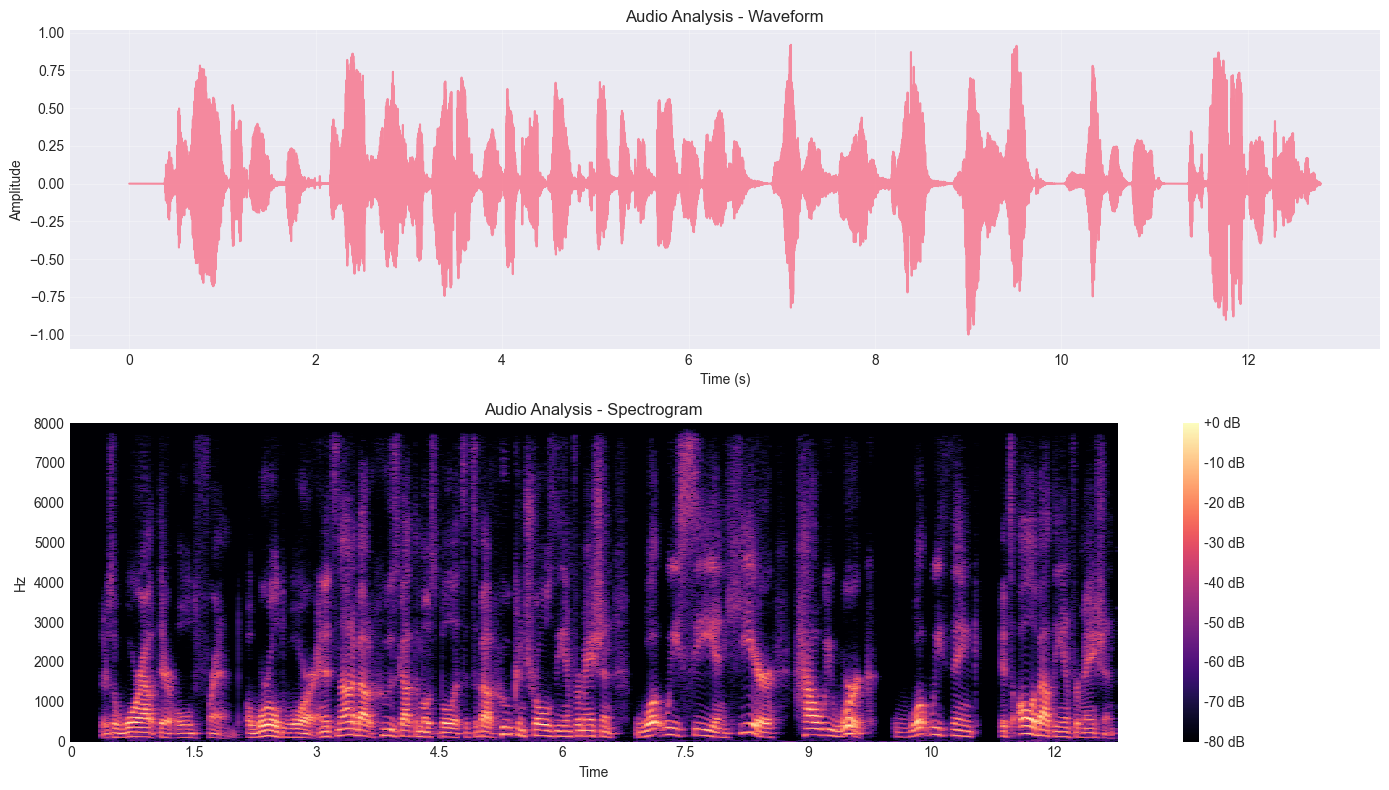

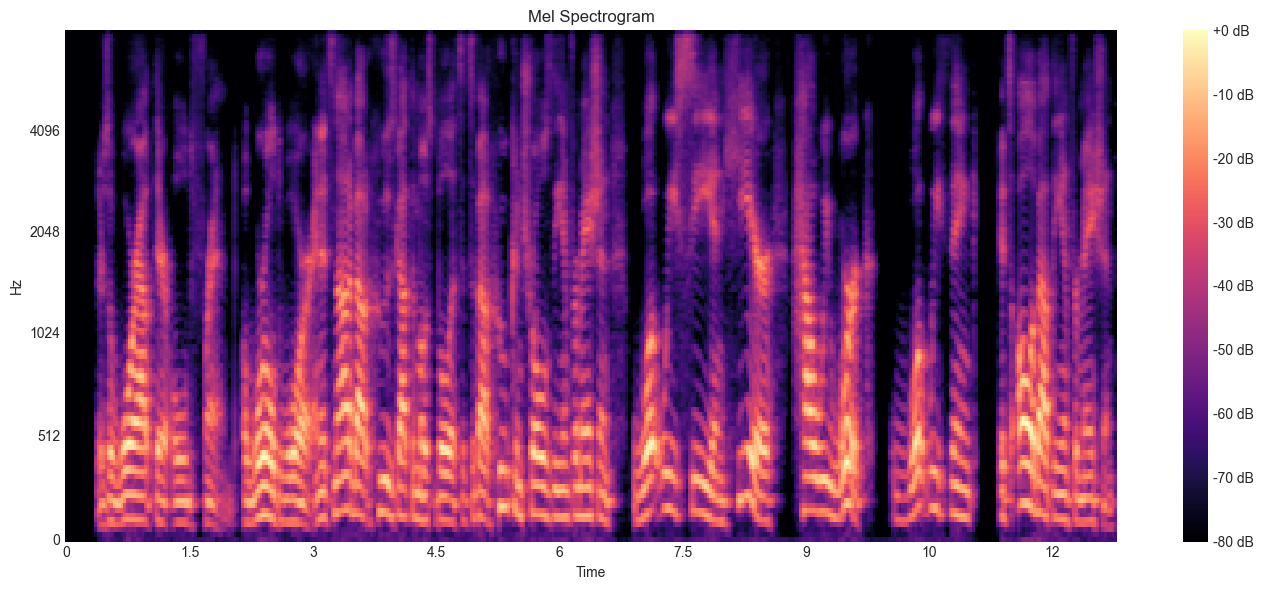

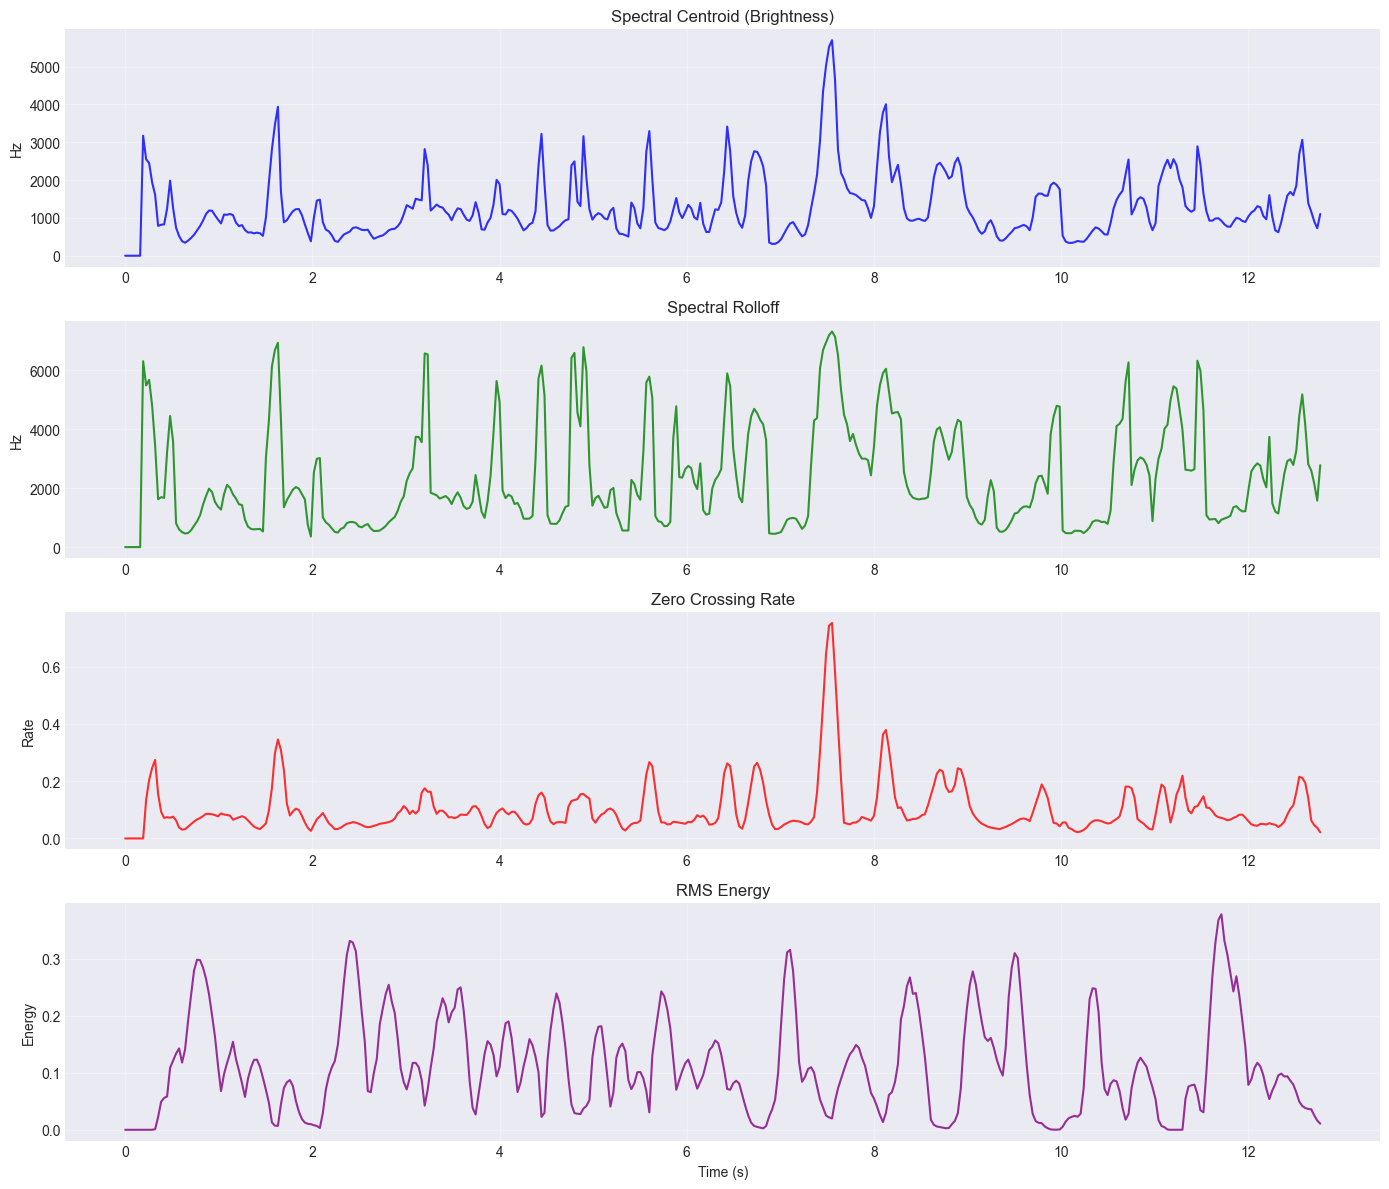

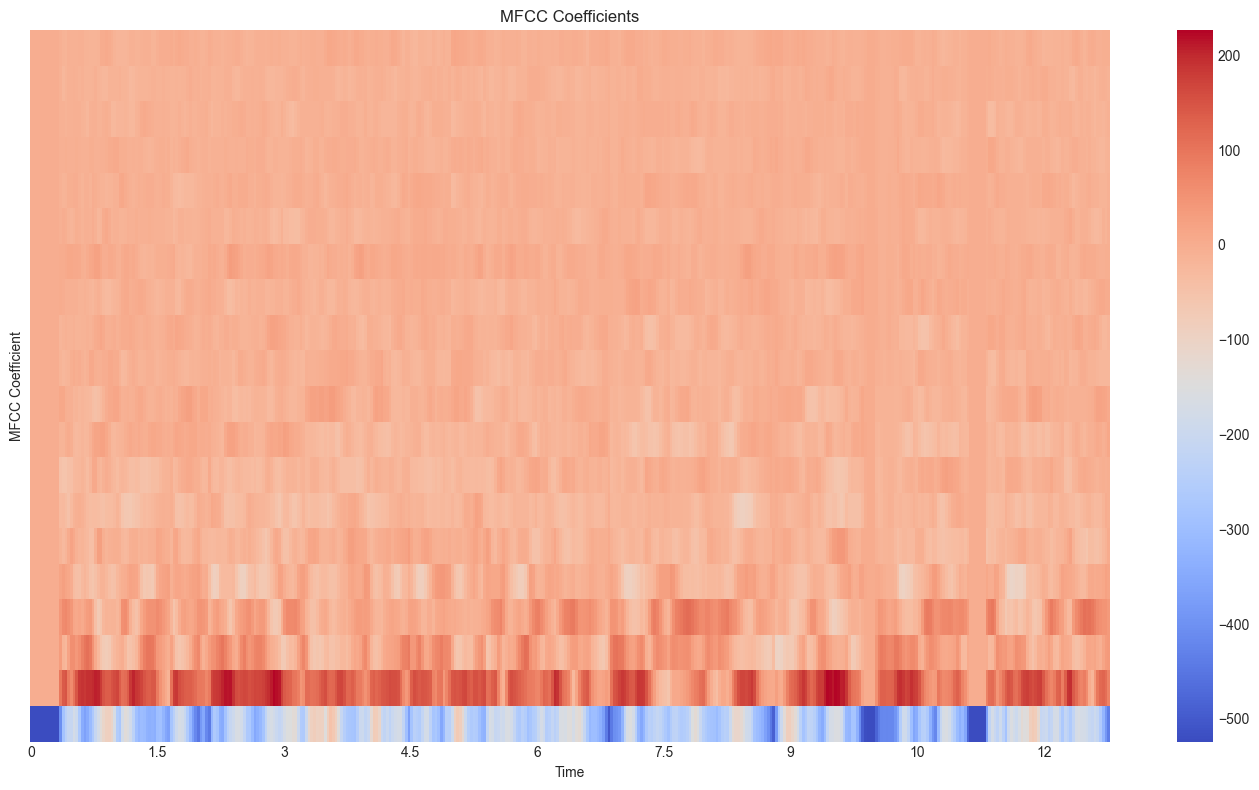

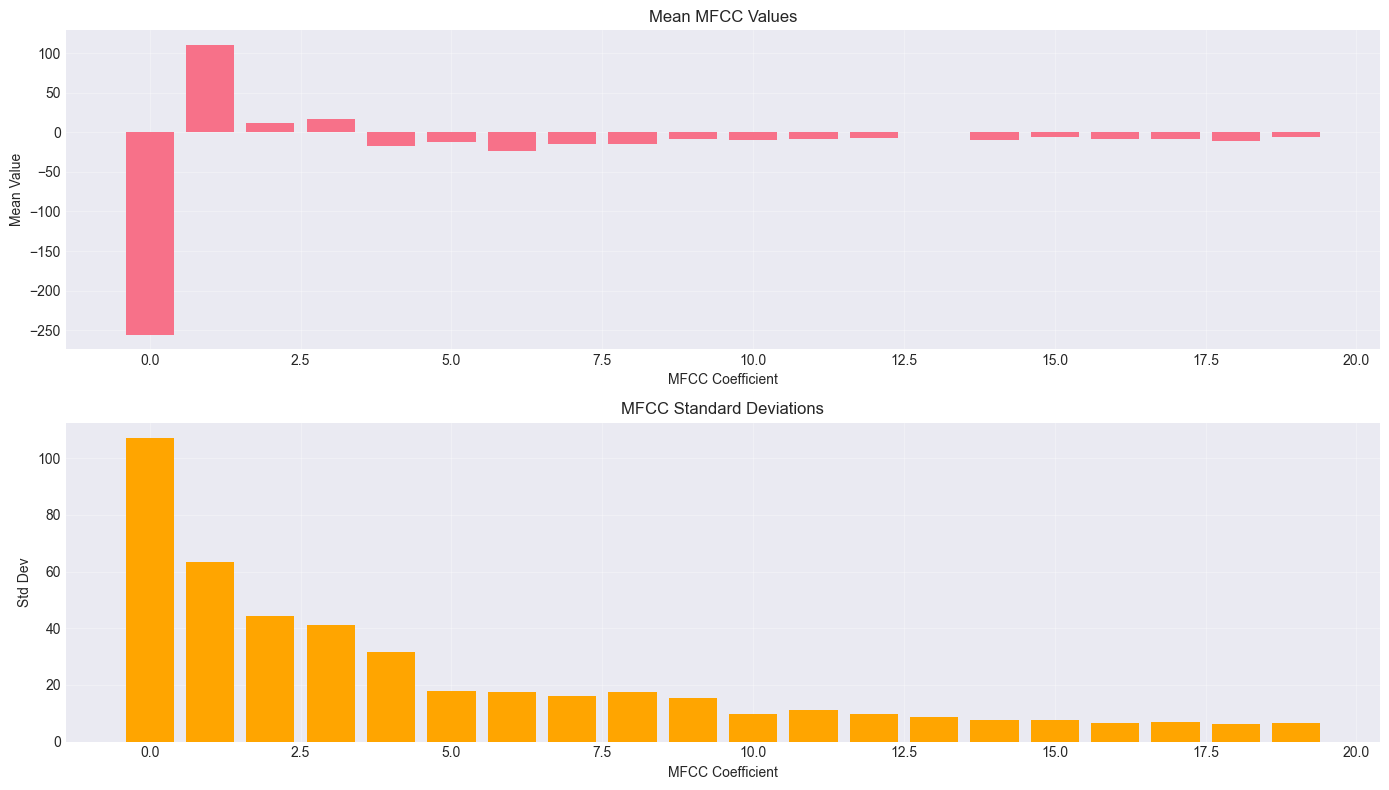

In [6]:
def plot_waveform_and_spectrogram(audio, sr, title="Audio Analysis"):
    """
    Plot waveform and spectrogram
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Waveform
    time = np.arange(len(audio)) / sr
    axes[0].plot(time, audio, alpha=0.8)
    axes[0].set_title(f'{title} - Waveform')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title(f'{title} - Spectrogram')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(audio, sr, title="Mel Spectrogram"):
    """
    Plot mel spectrogram - often reveals artifacts in deepfakes
    """
    plt.figure(figsize=(14, 6))
    
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Plot
    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(img, format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_spectral_features(audio, sr):
    """
    Plot various spectral features over time
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Frame parameters
    frame_length = 2048
    hop_length = 512
    
    # Spectral centroid
    cent = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=hop_length)[0]
    frames = range(len(cent))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    axes[0].plot(t, cent, label='Spectral Centroid', color='blue', alpha=0.8)
    axes[0].set_ylabel('Hz')
    axes[0].set_title('Spectral Centroid (Brightness)')
    axes[0].grid(True, alpha=0.3)
    
    # Spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=hop_length)[0]
    axes[1].plot(t, rolloff, label='Spectral Rolloff', color='green', alpha=0.8)
    axes[1].set_ylabel('Hz')
    axes[1].set_title('Spectral Rolloff')
    axes[1].grid(True, alpha=0.3)
    
    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)[0]
    axes[2].plot(t, zcr, label='ZCR', color='red', alpha=0.8)
    axes[2].set_ylabel('Rate')
    axes[2].set_title('Zero Crossing Rate')
    axes[2].grid(True, alpha=0.3)
    
    # RMS Energy
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    axes[3].plot(t, rms, label='RMS Energy', color='purple', alpha=0.8)
    axes[3].set_xlabel('Time (s)')
    axes[3].set_ylabel('Energy')
    axes[3].set_title('RMS Energy')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_mfcc_analysis(audio, sr):
    """
    Plot MFCC coefficients - useful for detecting synthesis artifacts
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    
    plt.figure(figsize=(14, 8))
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(img)
    plt.title('MFCC Coefficients')
    plt.ylabel('MFCC Coefficient')
    plt.tight_layout()
    plt.show()
    
    # Plot MFCC statistics
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Mean values
    mfcc_means = np.mean(mfccs, axis=1)
    axes[0].bar(range(20), mfcc_means)
    axes[0].set_title('Mean MFCC Values')
    axes[0].set_xlabel('MFCC Coefficient')
    axes[0].set_ylabel('Mean Value')
    axes[0].grid(True, alpha=0.3)
    
    # Standard deviations
    mfcc_stds = np.std(mfccs, axis=1)
    axes[1].bar(range(20), mfcc_stds, color='orange')
    axes[1].set_title('MFCC Standard Deviations')
    axes[1].set_xlabel('MFCC Coefficient')
    axes[1].set_ylabel('Std Dev')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the audio
plot_waveform_and_spectrogram(audio_data, sample_rate)
plot_mel_spectrogram(audio_data, sample_rate)
plot_spectral_features(audio_data, sample_rate)
plot_mfcc_analysis(audio_data, sample_rate)



## Advanced Analysis for Deepfake Detection
This section performs specialized analyses targeting common deepfake artifacts.

Phase Consistency Analysis:
Phase relationships in real speech are naturally variable due to the complex interaction of vocal tract components. Synthetic speech often has unnaturally consistent phase relationships.

What it analyzes:

- Phase Derivative Distribution: How phase changes between frequency bins
- Phase Coherence Over Time: Consistency of phase relationships
- Expected patterns: Real speech shows moderate variability; too much consistency suggests synthesis

Formant and Pitch Analysis:

- Formants are resonant frequencies of the vocal tract. Real speech has natural variations in formant frequencies and pitch.

What it analyzes:

- Formant Tracking: F1 and F2 frequencies over time using Linear Predictive Coding (LPC)
- Formant Stability: Standard deviation of formant frequencies
- Pitch Contour: Fundamental frequency variations
- Harmonic-to-Noise Ratio: Balance between harmonic and noise components

Red Flags:

- Formants that are too stable (low standard deviation)
- Unnaturally smooth pitch contours
- Very high HNR values (too periodic/perfect)

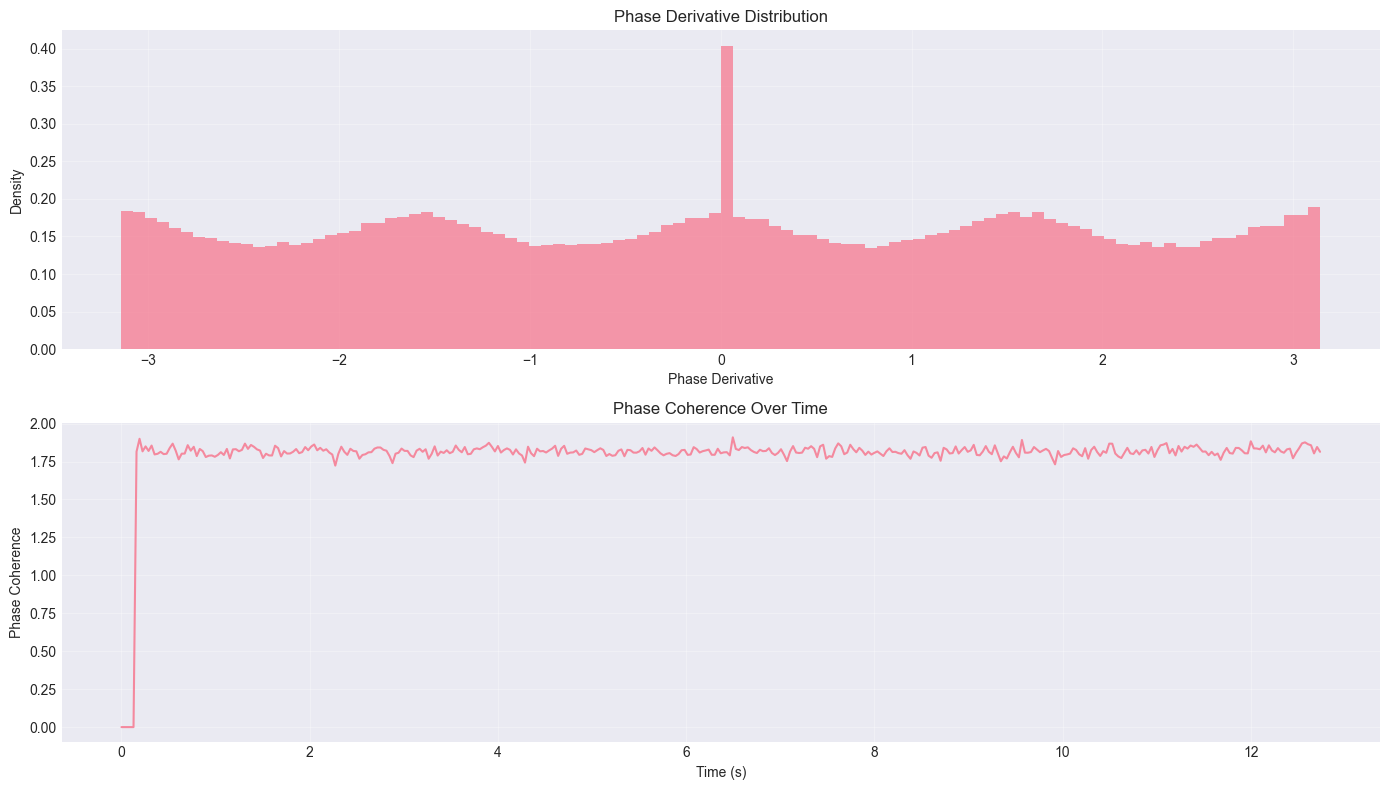

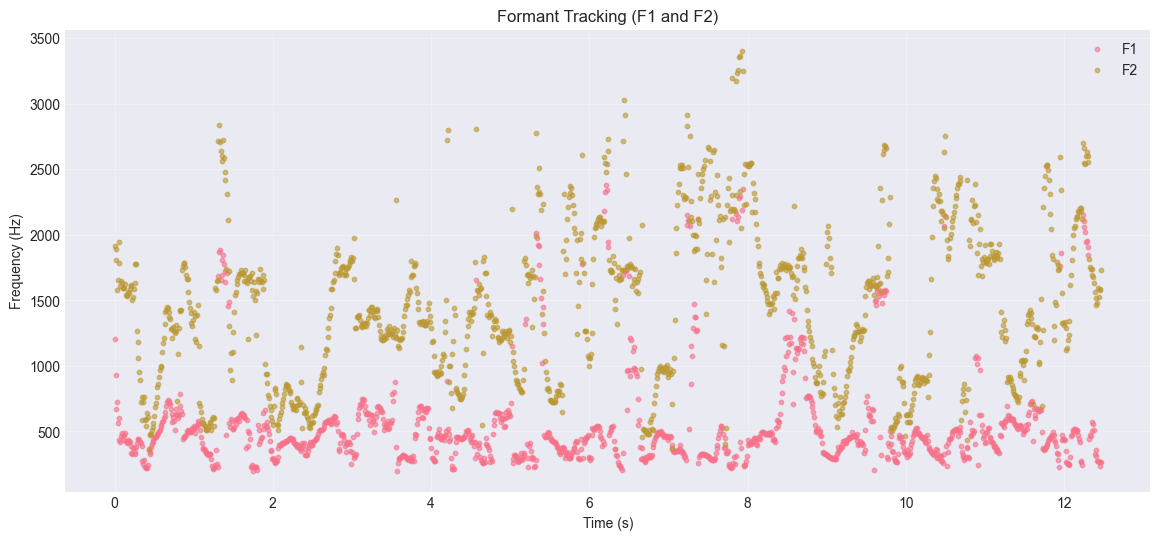

F1 Standard Deviation: 380.55 Hz
F2 Standard Deviation: 592.21 Hz


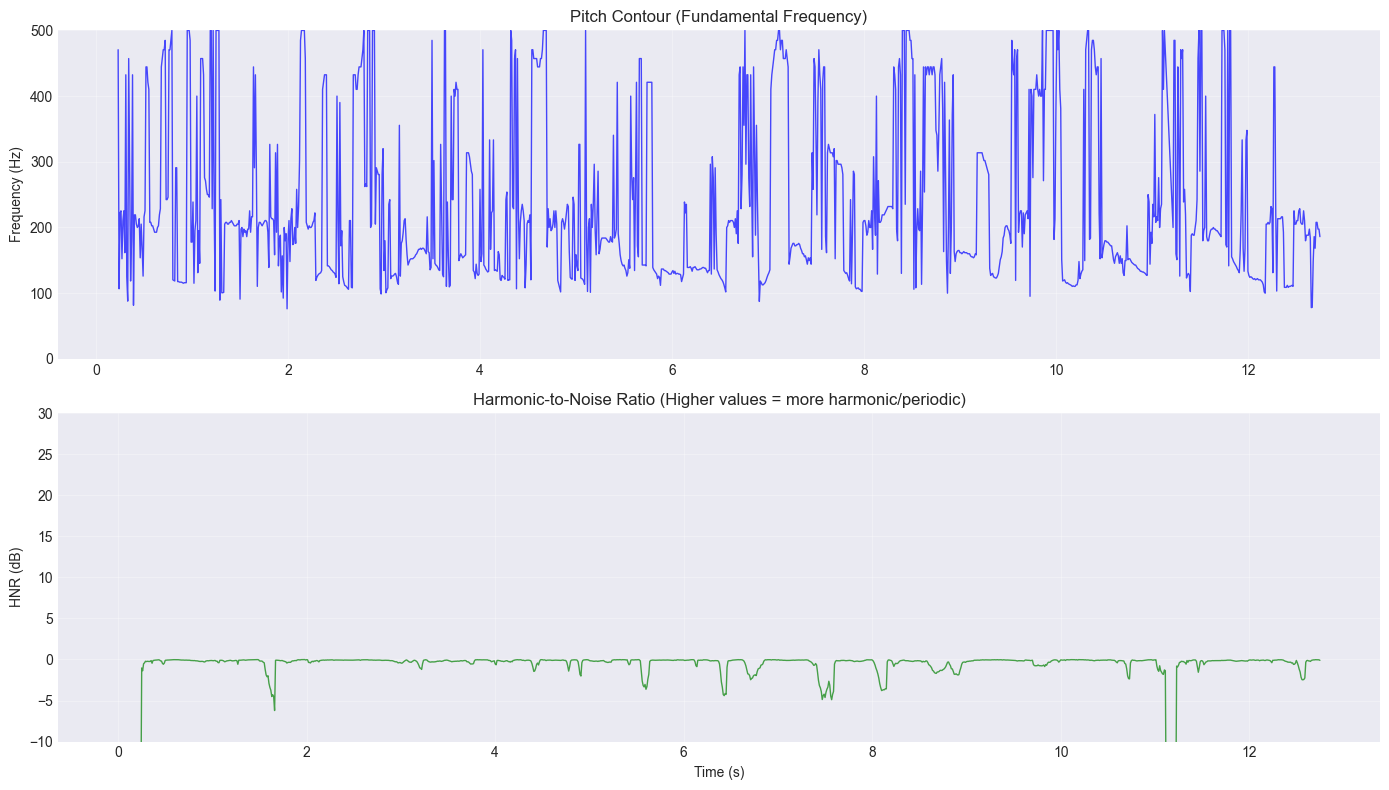

Pitch Statistics:
  Mean F0: 236.72 Hz
  F0 Std Dev: 124.01 Hz

HNR Statistics:
  Mean HNR: -0.95 dB
  HNR Std Dev: 3.34 dB


In [7]:
def analyze_phase_consistency(audio, sr):
    """
    Analyze phase consistency - deepfakes often have phase artifacts
    """
    # Compute STFT
    D = librosa.stft(audio)
    magnitude = np.abs(D)
    phase = np.angle(D)
    
    # Compute phase derivative (instantaneous frequency)
    phase_diff = np.diff(np.unwrap(phase, axis=1), axis=1)
    
    # Plot phase statistics
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Phase derivative histogram
    axes[0].hist(phase_diff.flatten(), bins=100, alpha=0.7, density=True)
    axes[0].set_title('Phase Derivative Distribution')
    axes[0].set_xlabel('Phase Derivative')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    
    # Phase coherence over time
    phase_coherence = np.std(phase_diff, axis=0)
    time_frames = librosa.frames_to_time(range(len(phase_coherence)), sr=sr)
    axes[1].plot(time_frames, phase_coherence, alpha=0.8)
    axes[1].set_title('Phase Coherence Over Time')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Phase Coherence')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return phase_diff

def analyze_formant_consistency(audio, sr):
    """
    Analyze formant frequencies - synthetic speech often has unnatural formants
    """
    try:
        # Estimate formants using LPC
        from scipy.signal import lfilter
        from scipy.signal.windows import hamming
        
        # Preprocess
        audio_filtered = librosa.effects.preemphasis(audio)
        
        # Window the signal
        frame_length = int(0.025 * sr)
        hop_length = int(0.010 * sr)
        
        formants_over_time = []
        
        for i in range(0, len(audio_filtered) - frame_length, hop_length):
            frame = audio_filtered[i:i + frame_length] * hamming(frame_length)
            
            try:
                # LPC analysis
                a = librosa.lpc(frame, order=16)
                
                # Find formants from LPC coefficients
                roots = np.roots(a)
                roots = roots[np.imag(roots) >= 0]
                
                # Convert to frequencies
                angles = np.angle(roots)
                freqs = sorted(angles * sr / (2 * np.pi))
                
                # Keep only reasonable formant frequencies
                formants = [f for f in freqs if 200 < f < 5000][:4]
                
                if len(formants) >= 2:
                    formants_over_time.append(formants[:2])  # F1 and F2
            except:
                # Skip problematic frames
                continue
        
        if formants_over_time:
            formants_array = np.array(formants_over_time)
            
            # Plot formant tracks
            plt.figure(figsize=(14, 6))
            time_points = np.arange(len(formants_array)) * hop_length / sr
            
            plt.scatter(time_points, formants_array[:, 0], alpha=0.6, s=10, label='F1')
            plt.scatter(time_points, formants_array[:, 1], alpha=0.6, s=10, label='F2')
            
            plt.title('Formant Tracking (F1 and F2)')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Formant stability analysis
            f1_std = np.std(formants_array[:, 0])
            f2_std = np.std(formants_array[:, 1])
            print(f"F1 Standard Deviation: {f1_std:.2f} Hz")
            print(f"F2 Standard Deviation: {f2_std:.2f} Hz")
        else:
            print("Could not extract sufficient formant data")
            
    except Exception as e:
        print(f"Formant analysis skipped due to error: {e}")
        print("This may occur with short audio clips or non-speech audio")

def analyze_pitch_and_harmonics(audio, sr):
    """
    Analyze pitch contour and harmonic structure - alternative to formant analysis
    """
    try:
        # Method 1: Fundamental frequency using autocorrelation
        plt.figure(figsize=(14, 8))
        
        # Compute short-time autocorrelation
        frame_length = int(0.025 * sr)
        hop_length = int(0.010 * sr)
        
        f0_values = []
        times = []
        
        for i in range(0, len(audio) - frame_length, hop_length):
            frame = audio[i:i + frame_length]
            
            # Apply window
            windowed = frame * np.hanning(len(frame))
            
            # Autocorrelation
            autocorr = np.correlate(windowed, windowed, mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            
            # Find peaks
            min_period = int(sr / 500)  # 500 Hz max
            max_period = int(sr / 50)   # 50 Hz min
            
            if max_period < len(autocorr):
                autocorr_subset = autocorr[min_period:max_period]
                if len(autocorr_subset) > 0 and np.max(autocorr_subset) > 0:
                    peak_idx = np.argmax(autocorr_subset) + min_period
                    f0 = sr / peak_idx
                    f0_values.append(f0)
                    times.append(i / sr)
        
        if f0_values:
            # Plot pitch contour
            plt.subplot(2, 1, 1)
            plt.plot(times, f0_values, 'b-', alpha=0.7, linewidth=1)
            plt.ylabel('Frequency (Hz)')
            plt.title('Pitch Contour (Fundamental Frequency)')
            plt.grid(True, alpha=0.3)
            plt.ylim(0, 500)
        
        # Method 2: Harmonic-to-Noise Ratio (HNR)
        # This can reveal synthesis artifacts
        hnr_values = []
        
        for i in range(0, len(audio) - frame_length, hop_length):
            frame = audio[i:i + frame_length]
            
            # Simple HNR estimation
            autocorr = np.correlate(frame, frame, mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            
            if len(autocorr) > 1:
                # Ratio of maximum autocorrelation to variance
                hnr = np.max(autocorr[1:]) / (autocorr[0] + 1e-10)
                hnr_db = 10 * np.log10(hnr + 1e-10)
                hnr_values.append(np.clip(hnr_db, -20, 40))
        
        if hnr_values:
            # Plot HNR
            plt.subplot(2, 1, 2)
            time_hnr = np.arange(len(hnr_values)) * hop_length / sr
            plt.plot(time_hnr, hnr_values, 'g-', alpha=0.7, linewidth=1)
            plt.ylabel('HNR (dB)')
            plt.xlabel('Time (s)')
            plt.title('Harmonic-to-Noise Ratio (Higher values = more harmonic/periodic)')
            plt.grid(True, alpha=0.3)
            plt.ylim(-10, 30)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        if f0_values:
            print(f"Pitch Statistics:")
            print(f"  Mean F0: {np.mean(f0_values):.2f} Hz")
            print(f"  F0 Std Dev: {np.std(f0_values):.2f} Hz")
        
        if hnr_values:
            print(f"\nHNR Statistics:")
            print(f"  Mean HNR: {np.mean(hnr_values):.2f} dB")
            print(f"  HNR Std Dev: {np.std(hnr_values):.2f} dB")
            
    except Exception as e:
        print(f"Pitch analysis error: {e}")
        print("Continuing with other analyses...")

# Perform advanced analysis
phase_diff = analyze_phase_consistency(audio_data, sample_rate)
analyze_formant_consistency(audio_data, sample_rate)
analyze_pitch_and_harmonics(audio_data, sample_rate)

## Pretrained Model Detection
This section uses state-of-the-art machine learning models for deepfake detection.

Models Used:

MelodyMachine Deepfake Detector (Primary Model - 50% weight):

Specifically trained to detect deepfaked audio
Outputs direct predictions: "FAKE", "REAL", "spoof", or "bonafide"
Most reliable indicator with high accuracy on modern TTS


Wav2Vec2 Feature Extraction:

Extracts deep audio representations
Analyzes embedding statistics for anomalies
Helps identify unusual audio patterns


Speech Characteristics Analysis:

Calculates zero-crossing rate and RMS energy patterns
These basic features have shown surprising effectiveness against F5-TTS


Spectral Anomaly Detection:

Identifies unusual spectral patterns
Calculates variance in spectral features
High anomaly scores indicate potential synthesis



How the Models Work:

The deepfake detector uses neural networks trained on thousands of real and fake audio samples
It learned to identify subtle patterns that distinguish synthetic from real speech
The model outputs confidence scores for each prediction

In [8]:
def detect_with_huggingface_models(audio_path):
    """
    Use various Hugging Face models for deepfake detection
    """
    results = {}
    
    # Model 1: Dedicated Deepfake Audio Detection Model
    try:
        print("Loading dedicated deepfake detection model...")
        from transformers import pipeline
        
        # Use the MelodyMachine deepfake detection model
        deepfake_detector = pipeline(
            "audio-classification",
            model="MelodyMachine/Deepfake-audio-detection-V2",
            device=-1  # Force CPU
        )
        
        # Get predictions
        predictions = deepfake_detector(audio_path)
        results['deepfake_detection'] = predictions
        
        print("Deepfake Detection Results:")
        for pred in predictions:
            print(f"  - {pred['label']}: {pred['score']:.4f}")
        
        # Extract the fake/real scores
        fake_score = 0.0
        real_score = 0.0
        for pred in predictions:
            if 'fake' in pred['label'].lower() or 'spoof' in pred['label'].lower():
                fake_score = max(fake_score, pred['score'])
            elif 'real' in pred['label'].lower() or 'genuine' in pred['label'].lower() or 'bonafide' in pred['label'].lower():
                real_score = max(real_score, pred['score'])
        
        results['deepfake_classifier_score'] = fake_score
        results['real_classifier_score'] = real_score
        
    except Exception as e:
        print(f"Deepfake detection model error: {e}")
        print("Make sure the model is downloaded. This may take a moment on first run.")
    
    # Model 2: Feature extraction with Wav2Vec2 (keep as supplementary)
    try:
        print("\nExtracting supplementary audio features...")
        from transformers import Wav2Vec2Processor, Wav2Vec2Model
        
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
        model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        
        # Load and process audio
        audio_input, sr = librosa.load(audio_path, sr=16000)
        inputs = processor(audio_input, sampling_rate=sr, return_tensors="pt", padding=True)
        
        # Extract features
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get the last hidden states
        hidden_states = outputs.last_hidden_state
        
        # Compute statistics on embeddings
        embedding_mean = hidden_states.mean().item()
        embedding_std = hidden_states.std().item()
        embedding_max = hidden_states.max().item()
        embedding_min = hidden_states.min().item()
        
        results['embedding_stats'] = {
            'mean': embedding_mean,
            'std': embedding_std,
            'max': embedding_max,
            'min': embedding_min,
            'range': embedding_max - embedding_min
        }
        
    except Exception as e:
        print(f"Feature extraction error: {e}")
    
    # Model 3: Speech characteristics analysis
    try:
        print("\nAnalyzing speech patterns...")
        audio_data, sr = librosa.load(audio_path, sr=16000)
        
        # Compute speech likelihood using zero-crossing rate and energy
        zcr = librosa.feature.zero_crossing_rate(audio_data)[0]
        rms = librosa.feature.rms(y=audio_data)[0]
        
        # Speech typically has specific ZCR and energy patterns
        speech_score = np.mean(zcr) * np.mean(rms) * 100
        
        results['speech_characteristics'] = {
            'zcr_mean': float(np.mean(zcr)),
            'rms_mean': float(np.mean(rms)),
            'speech_likelihood_score': float(speech_score)
        }
        
    except Exception as e:
        print(f"Speech analysis error: {e}")
    
    # Model 4: Spectral analysis for deepfake artifacts
    try:
        print("\nPerforming spectral anomaly detection...")
        audio_data, sr = librosa.load(audio_path, sr=16000)
        
        # Compute spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)[0]
        
        # Analyze spectral consistency
        centroid_variance = np.var(spectral_centroids)
        rolloff_variance = np.var(spectral_rolloff)
        
        # High variance might indicate artifacts
        anomaly_score = (centroid_variance / 1000000) + (rolloff_variance / 10000000)
        
        results['spectral_anomaly'] = {
            'centroid_variance': float(centroid_variance),
            'rolloff_variance': float(rolloff_variance),
            'anomaly_score': float(anomaly_score)
        }
        
    except Exception as e:
        print(f"Spectral analysis error: {e}")
    
    return results

# Run detection with pre-trained models
model_results = detect_with_huggingface_models(audio_file_path)

Loading dedicated deepfake detection model...


Device set to use cpu


Deepfake Detection Results:
  - fake: 0.9999
  - real: 0.0001

Extracting supplementary audio features...

Analyzing speech patterns...

Performing spectral anomaly detection...


## Ensamble Detection Score
Comprehensive Detection Score
This section combines all analyses into a final deepfake detection score.
Scoring System:
The system uses weighted averaging of multiple indicators:

Deepfake Model (50% weight): Direct prediction from specialized neural network
Speech Characteristics (20% weight): Based on calibration showing 3x difference between real/fake
Phase Coherence (10% weight): Synthetic speech often too consistent
Spectral Features (5% weight): Brightness and rolloff patterns
Other Features (15% total): Micro-temporal, anomaly scores, etc.

Score Interpretation:

0.0 - 0.4: Low risk (likely genuine)
0.4 - 0.7: Medium risk (suspicious, needs investigation)
0.7 - 1.0: High risk (likely deepfake)

Component Analysis:
Each feature contributes to the final score. The breakdown helps understand:

Which aspects triggered detection
Confidence in the result
Areas needing manual review

In [9]:
def calculate_deepfake_score(features, model_results):
    """
    Calculate a comprehensive deepfake detection score based on all analyses
    """
    scores = []
    weights = []
    component_details = {}
    
    # PRIORITY 1: Dedicated deepfake detection model (heavily weighted)
    if 'deepfake_classifier_score' in model_results:
        fake_score = model_results['deepfake_classifier_score']
        real_score = model_results.get('real_classifier_score', 0)
        
        # The model gives us direct fake/real probabilities
        # We'll use the fake score directly as our primary indicator
        scores.append(fake_score)
        weights.append(0.5)  # 50% weight - this is our most reliable indicator
        component_details['deepfake_model'] = fake_score
        
        # Also store confidence (how certain the model is)
        confidence = max(fake_score, real_score)
        component_details['model_confidence'] = confidence
    
    # 2. Speech characteristics (shown to be discriminative in your data)
    if 'speech_characteristics' in model_results:
        speech_score = model_results['speech_characteristics']['speech_likelihood_score']
        # Your data: Real avg ~0.36, Fake avg ~1.15
        if speech_score < 0.5:
            score = 0.1  # Likely real
        elif speech_score < 0.8:
            score = 0.4  # Uncertain
        elif speech_score < 1.0:
            score = 0.7  # Likely fake
        else:
            score = 0.85  # Very likely fake
            
        scores.append(score)
        weights.append(0.2)  # 20% weight
        component_details['speech_score'] = score
    
    # 3. Spectral feature analysis
    if 'spectral_rolloff_std' in features:
        rolloff_std = features['spectral_rolloff_std']
        optimal_range = (500, 2000)
        
        if rolloff_std < optimal_range[0]:
            score = 1.0 - (rolloff_std / optimal_range[0])
        elif rolloff_std > optimal_range[1]:
            score = min((rolloff_std - optimal_range[1]) / optimal_range[1], 1.0)
        else:
            score = 0.0
            
        scores.append(score)
        weights.append(0.05)
        component_details['spectral'] = score
    
    # 4. Phase coherence (if available)
    if 'phase_coherence_mean' in features:
        pc_mean = features['phase_coherence_mean']
        # F5-TTS often has high phase coherence
        if pc_mean > 0.9:
            score = 0.8  # Too coherent
        elif pc_mean > 0.7:
            score = 0.5
        elif pc_mean < 0.2:
            score = 0.6  # Too incoherent
        else:
            score = 0.2  # Normal range
            
        scores.append(score)
        weights.append(0.1)
        component_details['phase'] = score
    
    # 5. Micro-temporal variance
    if 'micro_temporal_variance' in features:
        mtv = features['micro_temporal_variance']
        if mtv < 0.0001:
            score = 0.8  # Very low variance - likely synthetic
        elif mtv < 0.001:
            score = 0.5
        else:
            score = 0.2  # Normal variance
        
        scores.append(score)
        weights.append(0.05)
        component_details['micro_temporal'] = score
    
    # 6. Spectral anomaly
    if 'spectral_anomaly' in model_results:
        anomaly = model_results['spectral_anomaly']['anomaly_score']
        if anomaly < 1.0:
            score = 0.3
        elif anomaly < 1.5:
            score = 0.5
        else:
            score = 0.7
            
        scores.append(score)
        weights.append(0.1)
        component_details['anomaly'] = score
    
    # Calculate weighted average
    if scores and weights:
        total_weight = sum(weights)
        weighted_score = sum(s * w for s, w in zip(scores, weights)) / total_weight
    else:
        weighted_score = 0.5  # Neutral score if no features available
    
    return weighted_score, component_details

# Calculate final score
deepfake_score, component_scores = calculate_deepfake_score(all_features, model_results)


## Results Visualization
The output includes three key visualizations:

Overall Score Bar: Color-coded risk level with threshold markers
Model Predictions: Shows what the neural network detected
Component Breakdown: Individual feature contributions

This multi-level view helps you:

See the final verdict at a glance
Understand which features triggered detection
Verify the model's confidence
Identify areas for manual review

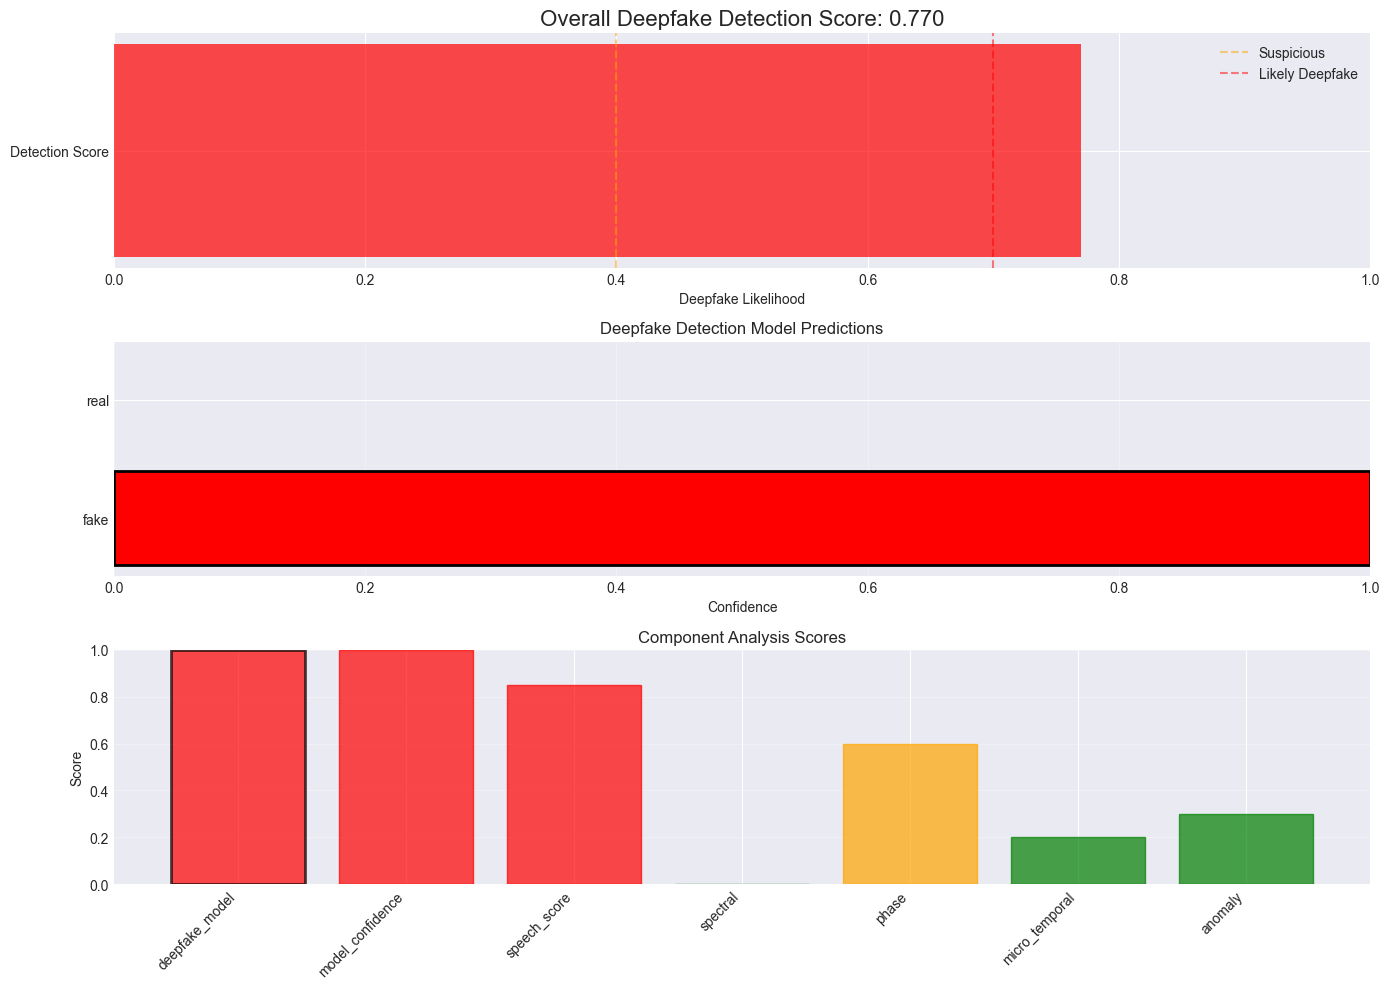


DEEPFAKE DETECTION RESULTS

Overall Deepfake Likelihood: 77.0%
⚠️  HIGH RISK: This audio shows strong indicators of being deepfaked

🤖 Dedicated Deepfake Model Predictions:
  - fake: 100.0%
  - real: 0.0%

Detailed Analysis:
  - Deepfake Model ⭐: 1.000
  - Model Confidence: 1.000
  - Speech Score: 0.850
  - Spectral: 0.000
  - Phase: 0.600
  - Micro Temporal: 0.200
  - Anomaly: 0.300

Model Confidence: 100.0%


In [10]:

# Visualize results
plt.figure(figsize=(14, 10))

# Score gauge with model confidence
ax1 = plt.subplot(3, 1, 1)
score_color = 'red' if deepfake_score > 0.7 else 'orange' if deepfake_score > 0.4 else 'green'
ax1.barh(['Detection Score'], [deepfake_score], color=score_color, alpha=0.7)
ax1.set_xlim(0, 1)
ax1.set_xlabel('Deepfake Likelihood')
ax1.set_title(f'Overall Deepfake Detection Score: {deepfake_score:.3f}', fontsize=16)

# Add threshold lines
ax1.axvline(x=0.4, color='orange', linestyle='--', alpha=0.5, label='Suspicious')
ax1.axvline(x=0.7, color='red', linestyle='--', alpha=0.5, label='Likely Deepfake')
ax1.legend()

# Model predictions if available
ax2 = plt.subplot(3, 1, 2)
if 'deepfake_detection' in model_results:
    predictions = model_results['deepfake_detection']
    labels = [p['label'] for p in predictions]
    scores = [p['score'] for p in predictions]
    colors = ['red' if 'fake' in l.lower() or 'spoof' in l.lower() else 'green' for l in labels]
    
    bars = ax2.barh(labels, scores, color=colors, alpha=0.7)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Confidence')
    ax2.set_title('Deepfake Detection Model Predictions')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Highlight the winning prediction
    max_idx = np.argmax(scores)
    ax2.barh(labels[max_idx], scores[max_idx], color=colors[max_idx], alpha=1.0, edgecolor='black', linewidth=2)

# Component scores
ax3 = plt.subplot(3, 1, 3)
if component_scores:
    components = list(component_scores.keys())
    values = list(component_scores.values())
    
    bars = ax3.bar(components, values, alpha=0.7)
    
    # Color bars based on score
    for bar, value in zip(bars, values):
        if value > 0.7:
            bar.set_color('red')
        elif value > 0.4:
            bar.set_color('orange')
        else:
            bar.set_color('green')
    
    # Highlight the deepfake model component if present
    if 'deepfake_model' in components:
        idx = components.index('deepfake_model')
        bars[idx].set_edgecolor('black')
        bars[idx].set_linewidth(2)
    
    ax3.set_ylim(0, 1)
    ax3.set_ylabel('Score')
    ax3.set_title('Component Analysis Scores')
    ax3.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*50)
print("DEEPFAKE DETECTION RESULTS")
print("="*50)
print(f"\nOverall Deepfake Likelihood: {deepfake_score:.1%}")

if deepfake_score > 0.7:
    print("⚠️  HIGH RISK: This audio shows strong indicators of being deepfaked")
elif deepfake_score > 0.4:
    print("⚠️  MEDIUM RISK: This audio shows some suspicious characteristics")
else:
    print("✅ LOW RISK: This audio appears to be genuine")

# Show model predictions if available
if 'deepfake_detection' in model_results:
    print("\n🤖 Dedicated Deepfake Model Predictions:")
    for pred in model_results['deepfake_detection']:
        print(f"  - {pred['label']}: {pred['score']:.1%}")

print("\nDetailed Analysis:")
for component, score in component_scores.items():
    if component == 'deepfake_model':
        print(f"  - {component.replace('_', ' ').title()} ⭐: {score:.3f}")
    else:
        print(f"  - {component.replace('_', ' ').title()}: {score:.3f}")

if 'model_confidence' in component_scores:
    print(f"\nModel Confidence: {component_scores['model_confidence']:.1%}")

if 'transcription' in model_results:
    print(f"\nTranscribed Text: {model_results['transcription']['text']}")

## Export Data 

Export Results
This section saves the analysis results for documentation and further review.
What Gets Exported:

Overall deepfake score and risk level
All component scores
Raw feature values
Model predictions
Timestamp and file information

Format:
Results are saved as JSON for easy parsing and integration with other tools.

In [11]:
def export_analysis_report(audio_path, features, model_results, deepfake_score, component_scores):
    """
    Export comprehensive analysis report
    """
    report = {
        'audio_file': audio_path,
        'analysis_timestamp': pd.Timestamp.now().isoformat(),
        'overall_deepfake_score': deepfake_score,
        'risk_level': 'HIGH' if deepfake_score > 0.7 else 'MEDIUM' if deepfake_score > 0.4 else 'LOW',
        'component_scores': component_scores,
        'audio_features': features,
        'model_predictions': model_results
    }
    
    # Save as JSON
    import json
    report_path = audio_path.replace('.wav', '_deepfake_analysis.json')
    
    # Convert numpy types to Python types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        return obj
    
    serializable_report = convert_to_serializable(report)
    
    with open(report_path, 'w') as f:
        json.dump(serializable_report, f, indent=2)
    
    print(f"\nAnalysis report saved to: {report_path}")
    
    return report

# Export the analysis
report = export_analysis_report(audio_file_path, all_features, model_results, deepfake_score, component_scores)


Analysis report saved to: deepfake_audio/derek_fake_cosmo_quote_deepfake_analysis.json


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]